<h3>Dependências</h3>

In [3]:
!pip install -r requirements

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

<h3>Parâmetros globais</h3>

In [17]:
# Coleta dos dados
SYMBOL = 'DIS'
START_DATE = '2018-01-01'
END_DATE = '2024-07-20'

# Hiperparâmetros
SEQ_LENGTH = 60
EPOCHS = 20
BATCH_SIZE = 32
LSTM_UNITS = 50

<h2><b>Hiperparâmetros</b></h2>

<h3><b>Quantidade de Neurônios (Unidades LSTM)</b></h3>
<l>
    <li><b>O que ajustar</b>: A quantidade de neurônios na camada LSTM (atualmente 50).</li>
    <li><b>Impacto</b>: Aumentar o número de unidades LSTM pode permitir que o modelo capture mais padrões complexos dos dados, mas também aumenta a complexidade do modelo e o risco de overfitting.</li>
    <li><b>Como ajustar</b>: Teste diferentes números, como 64, 100, 128 ou até mais dependendo do tamanho dos dados.</li>
</l>

In [ ]:
LSTM_UNITS = 50

<h3><b>Número de Camadas LSTM</b></h3>
<l>
    <li><b>O que ajustar</b>: Atualmente, você tem apenas uma camada LSTM. Adicionar mais camadas LSTM (redes profundas) pode ajudar a capturar padrões mais profundos.</li>
    <li><b>Impacto</b>: Mais camadas podem ajudar o modelo a capturar relações mais complexas, mas também aumentam o risco de overfitting e a necessidade de dados mais robustos.</li>
    <li><b>Como ajustar</b>: Adicione camadas com `return_sequences=True` nas camadas intermediárias e `return_sequences=False` na última camada.</li>
</l>

In [ ]:
# model.add(LSTM(units=64, return_sequences=True))
# model.add(LSTM(units=32, return_sequences=False))  # Segunda camada LSTM

<h3>Coleta dos dados</h3>

In [11]:
# Coleta dos dados de uma empresa com yfinance
data = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                            DIS         DIS         DIS         DIS   
Date                                                                        
2018-01-02 00:00:00+00:00  107.875175  111.800003  111.809998  108.559998   
2018-01-03 00:00:00+00:00  108.338326  112.279999  113.190002  111.449997   
2018-01-04 00:00:00+00:00  108.290077  112.230003  113.000000  111.629997   
2018-01-05 00:00:00+00:00  107.701492  111.620003  112.680000  111.239998   
2018-01-08 00:00:00+00:00  106.157669  110.019997  111.279999  109.540001   

Price                            Open    Volume  
Ticker                            DIS       DIS  
Date                                             
2018-01-02 00:00:00+00:00  108.949997  11014300  
2018-01-03 00:00:00+00:00  112.190002   9237900  
2018-01-04 00:00:00+00:00  112.949997   7417400  
2018-01-05 00:00:00+00:00  112.680000   6008300  
2018-01-08 00:00:00+00:00  110.88

<h3>Transformação dos dados</h3>

In [12]:
# Mantendo apenas a coluna "Close", que representa o preço de fechamento
data = data[['Close']]

# Normalizando os dados para que os valores fiquem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para transformar a série temporal em um conjunto de dados com janelas de tempo
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Criando sequências
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Redimensionando o X para o formato (amostras, seq_length, 1) exigido pela LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividindo os dados em treinamento (80%) e validação (20%)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

<h3>Construção do modelo LSTM</h3>

In [15]:
# Construção do modelo LSTM
model = Sequential()

# Definindo a entrada explicitamente
model.add(Input(shape=(SEQ_LENGTH, 1)))

# Adicionando uma camada LSTM com 50 neurônios
model.add(LSTM(units=LSTM_UNITS, return_sequences=False))

# Adicionando uma camada densa para a saída
model.add(Dense(1))

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Exibindo o resumo do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

<h3>Treinamento do modelo</h3>

In [18]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0552 - val_loss: 0.0045
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 9.8930e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 9.1241e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 8.9510e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 8.2617e-04
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 7.3288e-04
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 7.6094e-04
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 6.9439e-04
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 6.8084e-04
Epoch 12/20
40/40 ━━━━━━━━━━━━━

<h3>Avaliação do modelo</h3>

In [19]:
# Prevendo nos dados de validação
y_pred = model.predict(X_val)

# Inversão da escala dos valores de validação e predição
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Calculando as métricas
mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_val_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE: 1.9167235272485506
RMSE: 2.50012224919135
MAPE: 0.020149481321930673


<h3>Visualização dos resultados</h3>

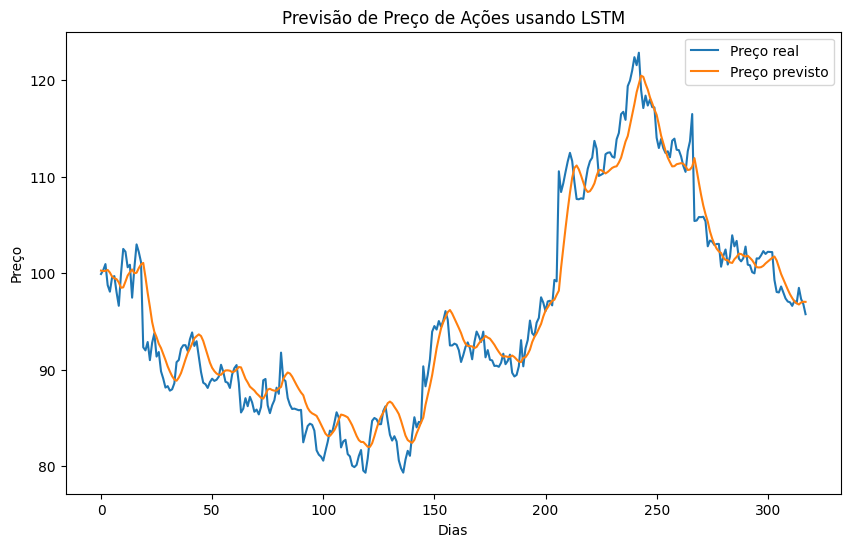

In [20]:
# Plotando os resultados reais e previstos
plt.figure(figsize=(10,6))
plt.plot(y_val_rescaled, label="Preço real")
plt.plot(y_pred_rescaled, label="Preço previsto")
plt.title('Previsão de Preço de Ações usando LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.show()